# 그랩컷 개선 방안 테스트
- 1.이미지를 전처리하고 그랩컷 실행 => 별로임 
- 2.딥러닝 사전학습된 세그먼트 모델이 전경에서 세그먼트해줌 => 책페이지에 대한 도메인이 아닌 모델이기 때문에 별로임 
- 3.이미지 이진화 때리고 그랩컷  => 개별로임

- 추가적인 개선
    - 리사이징 하는 방법 조사
    - 마스크 이미지를 완전 흑백으로 바꿔서 원하는 경로에 저장하는방법

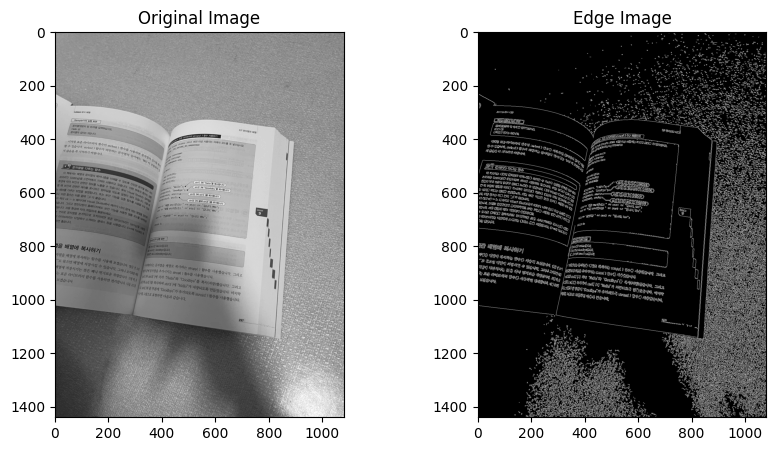

In [9]:
# 이미지 전처리로 개선할수있을지 테스트
import cv2
from matplotlib import pyplot as plt

# 이미지 불러오기
img = cv2.imread('./test_data/img/KakaoTalk_20240213_090413133_01.jpg', cv2.IMREAD_GRAYSCALE)  # 그레이스케일로 불러오기

# # 히스토그램 등화 적용
# img_eq = cv2.equalizeHist(img)
# # 결과 표시
# plt.figure(figsize=(10, 5))
# plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title('Original Image')
# plt.subplot(122), plt.imshow(img_eq, cmap='gray'), plt.title('Histogram Equalized')
# plt.show()

###########

# # 가우시안 블러 적용
# img_blur = cv2.GaussianBlur(img, (5, 5), 0)
# # 중간값 필터 적용
img_median = cv2.medianBlur(img, 5)
# # 결과 표시
# plt.figure(figsize=(15, 5))
# plt.subplot(131), plt.imshow(img, cmap='gray'), plt.title('Original Image')
# plt.subplot(132), plt.imshow(img_blur, cmap='gray'), plt.title('Gaussian Blurred')
# plt.subplot(133), plt.imshow(img_median, cmap='gray'), plt.title('Median Blurred')
# plt.show()

####################

# Canny 에지 검출
edges = cv2.Canny(img, 100, 200)
# 결과 표시
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title('Original Image')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge Image')
plt.show()


In [9]:
# 사전학습된 세그먼트모델을 활용할수있을지 테스트
import torch
from torchvision import models
from torchvision import transforms
from PIL import Image
from matplotlib import pyplot as plt

# 사전 학습된 DeepLabv3 모델 불러오기
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()  # 평가 모드로 설정


# 이미지 전처리 파이프라인
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 이미지 불러오기 및 전처리
image_path = './test_data/img/KakaoTalk_20240213_090413133_01.jpg'
input_image = Image.open(image_path)
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # 배치 차원 추가

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

# 마스크를 이미지로 변환
mask = output_predictions.byte().cpu().numpy()
plt.imshow(mask)
# 별로임 잘모르겠음 

c:\Users\82105\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\82105\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


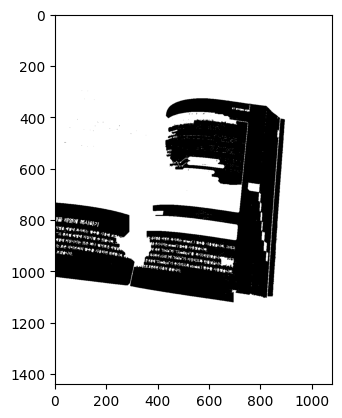

In [18]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

# Read the original image
img_path = "./test_data/img/KakaoTalk_20240213_090413133_01.jpg"
original_image = cv2.imread(img_path)

height, width, _ = original_image.shape
left_margin_proportion = 0.3
right_margin_proportion = 0.3
up_margin_proportion = 0.1
down_margin_proportion = 0.1

boundary_rectangle = (
    int(width * left_margin_proportion),
    int(height * up_margin_proportion),
    int(width * (1 - right_margin_proportion)),
    int(height * (1 - down_margin_proportion)),
)

# Set the seed for reproducibility purposes
cv2.setRNGSeed(0)

# 이진화된 이미지데이터로 개선할수있는지 테스트
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')

binarized_image = cv2.adaptiveThreshold(
    gray_image,
    maxValue=1,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY,
    blockSize=9,
    C=7,
)

# Initialize the mask with known information
mask = np.zeros((height, width), np.uint8)
mask[:] = cv2.GC_PR_BGD
mask[binarized_image == 0] = cv2.GC_FGD

# Arrays used by the algorithm internally
background_model = np.zeros((1, 65), np.float64)
foreground_model = np.zeros((1, 65), np.float64)

number_of_iterations = 5

cv2.grabCut(
    original_image,
    mask,
    boundary_rectangle,
    background_model,
    foreground_model,
    number_of_iterations,
    cv2.GC_INIT_WITH_MASK,
)

grabcut_mask = np.where((mask == cv2.GC_PR_BGD) | (mask == cv2.GC_BGD), 0, 1).astype(
    "uint8"
)
plt.imshow(grabcut_mask, cmap='gray')


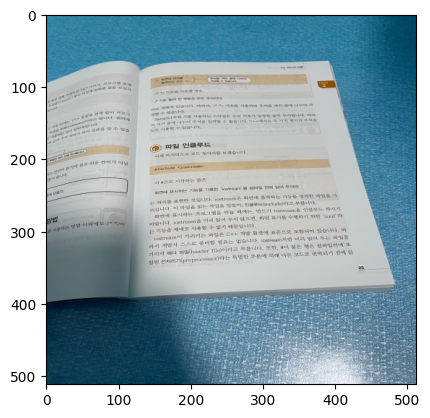

In [19]:
# 이미지 리사이징하기
import sys
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt

import tkinter as tk
from tkinter import filedialog

image_path= './test_data/img/KakaoTalk_20240213_090413133.jpg'
img = cv2.imread(image_path)
# 평균 보간 기법으로 리사이징하는것이다
img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_AREA)
plt.imshow(img)

In [ ]:
# 그랩컷 마스크이미지 흑백으로 바꾸고 결과물 저장하는 방법

# 생성된 마스크의 객체가 있는 위치는 
# 흰색(값 1), 배경은 검은색(값 0)으로 표시되는 이진 이미지로 변환하는것과
# 같은이름으로 저장하는것 구현함
import sys
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

image_path= './img_data/2QzDgg_3.png'

img = cv.imread(image_path)
assert img is not None, "file could not be read, check with os.path.exists()"
mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

# 지사각형 지정 => 마우스로 좌표 클릭 기능 추가 하면 될듯 
img.shape # (512, 512, 3) 이크기안에 들어오면됨
#        x1, y1 x2 y2
rect = (50,50,450,290)

cv.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8') *255

# 이렇게하면 원본이미지에서 객체 검출
# img = img*mask2[:,:,np.newaxis]
# plt.imshow(img), plt.colorbar(), plt.show()

# 이렇게하면 흑(배경)백(객체)로 추출한거 보기
plt.imshow(mask2, cmap='gray'), plt.colorbar(), plt.show()


# 수정하는 기능 추가해야됨

# 출력 파일 경로 생성
# os.path.basename을 사용하여 파일 이름 추출
# os.path.splitext을 사용하여 파일 이름과 확장자 분리
filename, file_extension = os.path.splitext(os.path.basename(image_path))
output_path = os.path.join('./segmented', filename + file_extension)

if not os.path.exists('./segmented'):
    os.makedirs('./segmented')

# 마스크 저장
cv.imwrite(output_path, mask2)
print('이미지 저장했음')
